In [132]:
## load libraries
library(ggplot2)
library(ggfortify)
library(GGally)
library(e1071)
library(class)
library(psych)
library(readr)
library(caret)     

In [107]:
## read dataset
wine <- read_csv("wine_data.csv", col_names = FALSE, show_col_types = FALSE)

## set column names
names(wine) <- c("Type","Alcohol","Malic acid","Ash","Alcalinity of ash","Magnesium","Total phenols","Flavanoids","Nonflavanoid Phenols","Proanthocyanins","Color.Intensity","Hue","Od280/od315 of diluted wines","Proline")
wine$Type <- as.factor(wine$Type)


## inspect data frame
head(wine)
     

Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color.Intensity,Hue,Od280/od315 of diluted wines,Proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [72]:
# ## split train/test
N <- nrow(wine)
train.indexes <- sample(N,0.8*N)

train <- wine[train.indexes,]
test <- wine[-train.indexes,]

features <- c("Alcohol", "Color.Intensity")
train_sub <- train[, c("Type", features)]
test_sub  <- test[, c("Type", features)]

### Linear Kernel


Call:
best.svm(x = Type ~ ., data = train_sub, cost = seq(0.1, 10, by = 0.5), 
    kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.6 

Number of Support Vectors:  63

 ( 17 24 22 )


Number of Classes:  3 

Levels: 
 1 2 3




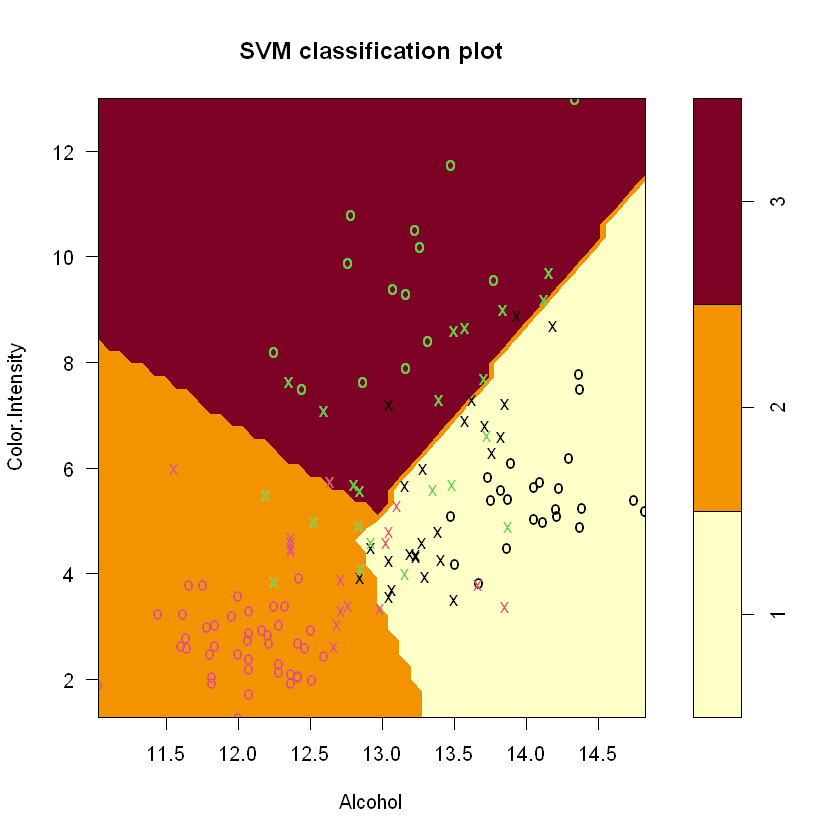

In [77]:
# ---- SVM with Linear Kernel ----

svm_linear_tune <- tune.svm(Type ~ ., data = train_sub,
                            kernel = "linear",
                            cost = seq(0.1, 10, by = 0.5))

best_linear <- svm_linear_tune$best.model
summary(best_linear)

plot(best_linear, data = train_sub,
     formula = Color.Intensity ~ Alcohol,
     svSymbol = "x", dataSymbol = "o",
     main = "SVM classification plot (Linear)")


### Radial Kernel


Call:
best.svm(x = Type ~ ., data = train_sub, gamma = seq(0.001, 0.1, 
    by = 0.005), cost = seq(0.1, 10, by = 0.5), kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  2.6 

Number of Support Vectors:  67

 ( 18 25 24 )


Number of Classes:  3 

Levels: 
 1 2 3




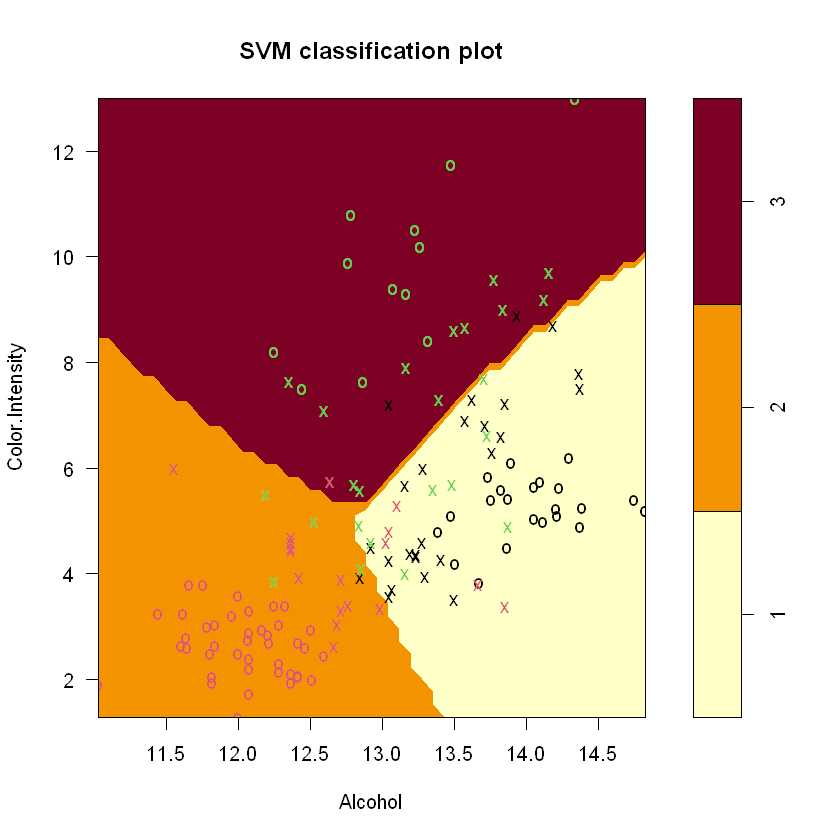

In [113]:
# ---- SVM RBF Kernel ----
svm_rbf_tune <- tune.svm(Type ~ ., data = train_sub,
                         kernel = "radial",
                         gamma = seq(0.001, 0.1, by = 0.005),
                         cost = seq(0.1, 10, by = 0.5))

best_rbf <- svm_rbf_tune$best.model
summary(best_rbf)


plot(svm_rbf_tune$best.model, data = train_sub,
     formula = Color.Intensity ~ Alcohol,
     svSymbol = "x", dataSymbol = "o",
     main = "SVM classification plot (RBF)")


### Comparing the different kernels-- evaluation

In [115]:
# ---- Predictions and evaluation ----
pred_linear <- predict(best_linear, test_sub[, features])
pred_rbf <- predict(best_rbf, test_sub[, features])


# ---- Confusion matrices ----
cm_linear <- table(Actual = test_sub$Type, Predicted = pred_linear)
cm_rbf    <- table(Actual = test_sub$Type, Predicted = pred_rbf)

# ---- Function to compute metrics manually ----
compute_metrics <- function(cm) {
  n <- sum(cm)
  nc <- nrow(cm)
  diag_vals <- diag(cm)
  rowsums <- apply(cm, 1, sum)
  colsums <- apply(cm, 2, sum)
  p <- rowsums / n
  q <- colsums / n
  
  accuracy <- sum(diag_vals) / n
  recall <- diag_vals / rowsums
  precision <- diag_vals / colsums
  f1 <- 2 * precision * recall / (precision + recall)
  
  list(
    accuracy = accuracy,
    metrics = data.frame(precision, recall, f1)
  )
}

# ---- Compute metrics for SVMs ----
metrics_linear <- compute_metrics(cm_linear)
metrics_rbf <- compute_metrics(cm_rbf)

cat("\n--- SVM (Linear Kernel) ---\n")
print(cm_linear)
cat("\nAccuracy:", metrics_linear$accuracy, "\n")
print(metrics_linear$metrics)

cat("\n--- SVM (RBF Kernel) ---\n")
print(cm_rbf)
cat("\nAccuracy:", metrics_rbf$accuracy, "\n")
print(metrics_rbf$metrics)


--- SVM (Linear Kernel) ---
      Predicted
Actual  1  2  3
     1 12  0  0
     2  2 10  0
     3  3  2  7

Accuracy: 0.8055556 
  precision    recall        f1
1 0.7058824 1.0000000 0.8275862
2 0.8333333 0.8333333 0.8333333
3 1.0000000 0.5833333 0.7368421

--- SVM (RBF Kernel) ---
      Predicted
Actual  1  2  3
     1 12  0  0
     2  2 10  0
     3  4  2  6

Accuracy: 0.7777778 
  precision    recall        f1
1 0.6666667 1.0000000 0.8000000
2 0.8333333 0.8333333 0.8333333
3 1.0000000 0.5000000 0.6666667


### KNN on same features

In [127]:
# KNN
wine.knn.df1 <- wine[, c("Type", "Alcohol", "Color.Intensity")]

# Train classifier to predict wine type
#compute train/test splits
s.train1 <- sample(nrow(wine.knn.df1), floor(0.8 * nrow(wine.knn.df1)))
wine.train1 <- wine.knn.df1[s.train1, ]
wine.test1  <- wine.knn.df1[-s.train1, ]

# sequence of k values
k.values <- seq(1, 25, by = 2)
acc1 <- numeric(length(k.values))
cms1 <- vector("list", length(k.values))

# loop over k
for (i in seq_along(k.values)) {
  k <- k.values[i]
  knn.pred <- knn(train = as.matrix(wine.train1[, 2:3]), test =  as.matrix(wine.test1[, 2:3]), cl = wine.train1[[1]] , k = k)
  cm <- table(predicted = knn.pred, actual = wine.test1[[1]]) 
  cms1[[i]] <- cm
  acc1[i] <- sum(diag(cm)) / sum(cm)
}

# best model summary
best.k1 <- k.values[which.max(acc1)]
best.cm1 <- cms1[[which.max(acc1)]]

best.k1 # print best k
best.cm1         
max(acc1) # print accuracy

n <- sum(best.cm1)
diagv <- diag(best.cm1)
rowsums <- apply(best.cm1, 1, sum)
colsums <- apply(best.cm1, 2, sum)

accuracy <- sum(diagv) / n
precision <- diagv / colsums
recall <- diagv / rowsums
f1 <- 2 * precision * recall / (precision + recall)
data.frame(precision, recall, f1)
accuracy

[1] 7

         actual
predicted  1  2  3
        1 14  2  2
        2  0 13  0
        3  0  0  5

[1] 0.8888889

,precision,recall,f1
,<dbl>,<dbl>,<dbl>
1,1.0000000,0.7777778,0.8750000
2,0.8666667,1.0000000,0.9285714
3,0.7142857,1.0000000,0.8333333


[1] 0.8888889

##### Knn performs slightly better than the SVM models